<a href="https://colab.research.google.com/github/siddharth3444/detect_window/blob/main/train_model_with_checkpoints_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
%pip install transformers accelerate optuna torch-summary albumentations wandb opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
 !unzip -o /content/drive/MyDrive/Dataset/All_Images.zip -d ./images

Streaming output truncated to the last 5000 lines.
  inflating: ./images/All_Images/annotations/clqdbaaag0a060752xtsghhhe.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a070752pa8fulft.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a080752umzffj0l.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a090752ldfe1q7l.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a0a07523vsmfyjl.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a0b0752qln71nbz.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a0c075211a634bl.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a0d07529eo3r9of.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a0e0752okistz37.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a0f0752ie5puqfs.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a0g07526lmsv551.png  
  inflating: ./images/All_Images/annotations/clqdbaaag0a0h0752r1f3mdyv.png  
  inflating: ./images/All

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split


dir="/content/images/All_Images"
image_data_dir=f'{dir}/images'
annotation_data_dir=f'{dir}/annotations'

dataset=[]
idx=1
for item in os.listdir(f"{image_data_dir}/"):
  obj={}
  name=item.split(".")[0]
  obj['image']=Image.open(f"{image_data_dir}/{name}.jpg")
  obj['annotation']=Image.open(f"{annotation_data_dir}/{name}.png")
  obj['_id']=idx
  dataset.append(obj)

new_data=dataset
train_data, test_data =  train_test_split(new_data,test_size=0.2,random_state=42)

print(f" Training Data {len(train_data)}")
print(f" Testing Data {len(test_data)}")


 Training Data 2400
 Testing Data 600


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=980x979 at 0x7AAA95151F30>
[0 1 2 3 4 5 6 7 8 9]
[0 1 3 4 5]


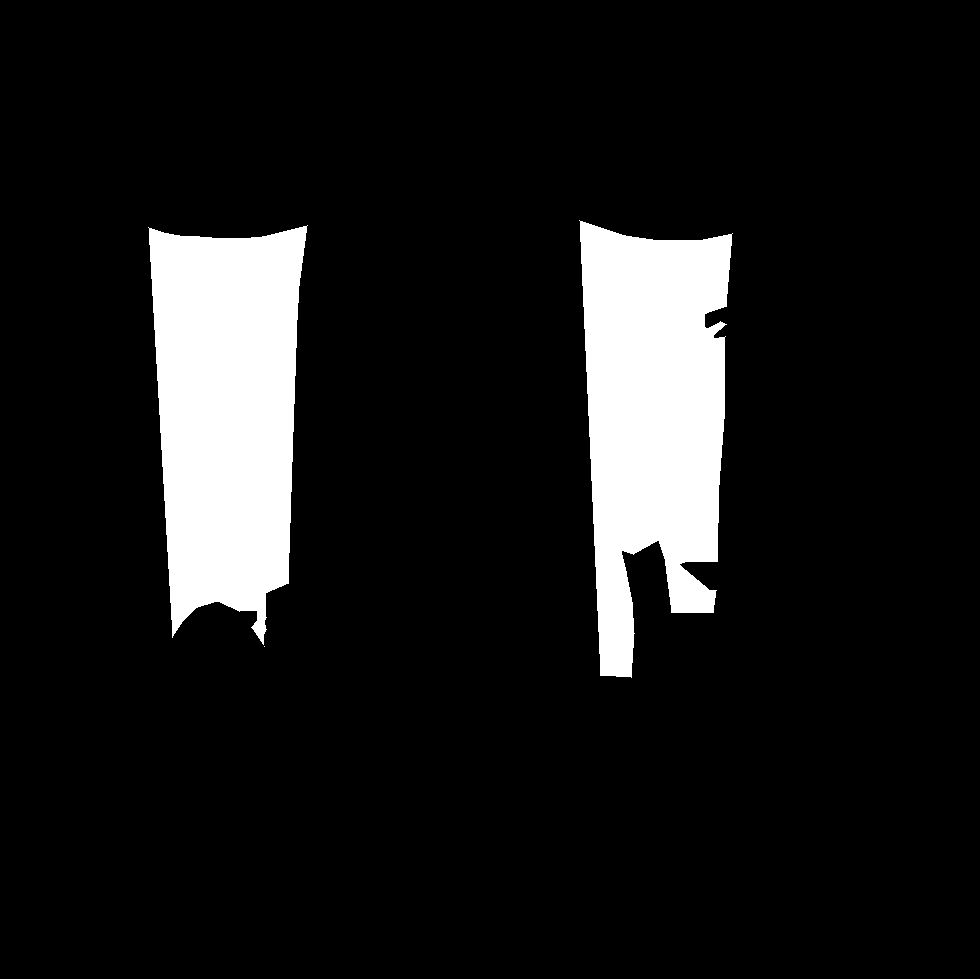

In [ ]:
id2label={ 5:'windowpane',4:'curtain',3:'blinds',2:'door',0:'wall',1:'floor'}
import numpy as np
index=3
print(train_data[index]['annotation'])
obj=np.array(train_data[index]['annotation'])
instance_seg=obj[...,1]
se_seg=obj[...,0]
print(np.unique(instance_seg))
print(np.unique(se_seg))
mask = (se_seg==5)
visual_mask = (mask * 255).astype(np.uint8)
Image.fromarray(visual_mask)

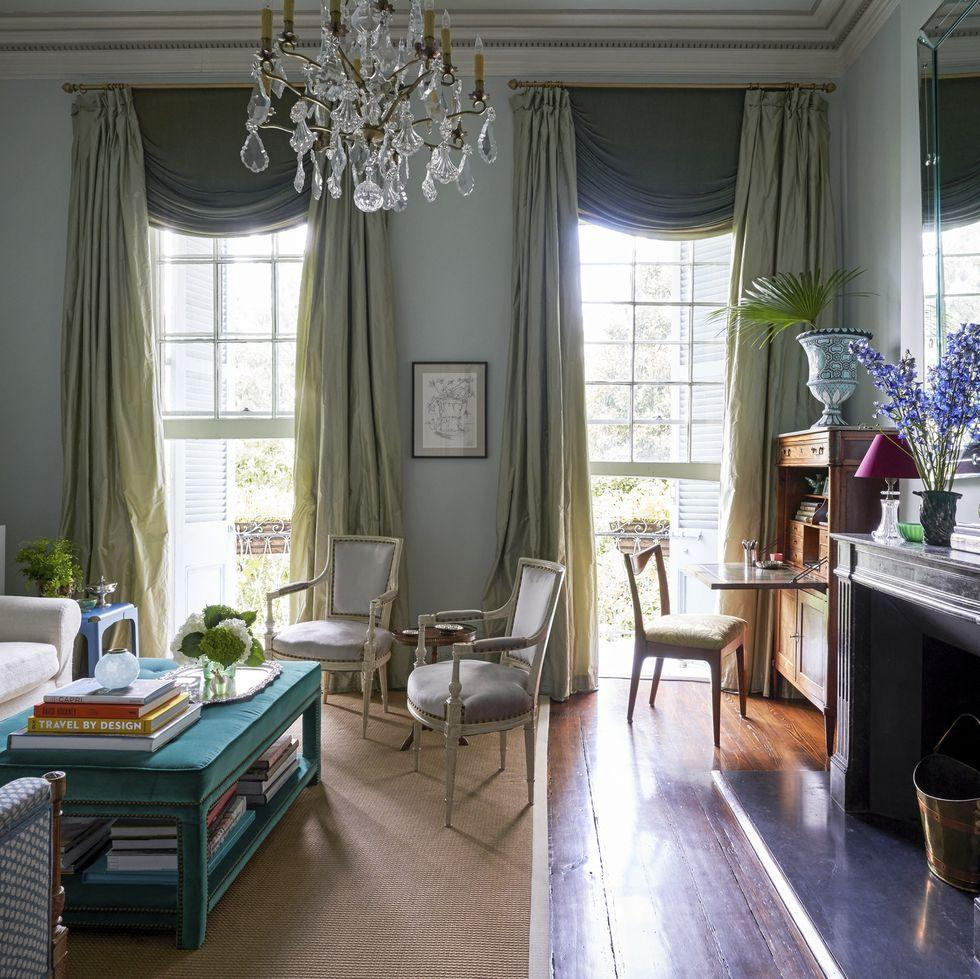

In [ ]:
train_data[index]['image']

In [ ]:
from transformers import MaskFormerImageProcessor
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from torch.utils.data import DataLoader


processor = MaskFormerImageProcessor(do_reduce_labels=True,ignore_index=255, do_resize=False, do_rescale=False, do_normalize=True)


class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self,dataset,processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]['image'].convert("RGB"))
        instance_seg = np.array(self.dataset[idx]['annotation'])[:,:,1]
        class_id_map = np.array(self.dataset[idx]['annotation'])[:,:,0]
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs



ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# note that you can include more fancy data augmentation methods here
train_transform = A.Compose([
    A.Resize(width=512, height=512),
    #A.RandomResizedCrop(width=512, height=512, scale=(0.5, 1.0)),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=45),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

train_dataset = ImageSegmentationDataset(train_data, processor=processor, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_data, processor=processor, transform=train_transform)

def freeze_layer(model):
    for param in model.parameters():
           param.requires_grad = False

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

In [ ]:
import torch
import gc
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.cuda.empty_cache()
gc.collect()

57

In [ ]:
import json
b_t={"optim": "adamw_torch", "learning_rate": 9.971930719778446e-05, "per_device_train_batch_size": 10, "weight_decay": 0.00019277664635316874, "num_decoder_layers": 6, "auxiliary_loss_weight": 0.2004091340099437, "dice_weight": 0.3280037047000379, "cross_entropy_weight": 0.207234463928762, "mask_weight": 1.9803763515498707, "init_xavier_std": 0, "init_std": 0.930439651714732, "num_train_epochs": 3, "batch_size": 32}

In [ ]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
from transformers import MaskFormerForInstanceSegmentation,MaskFormerModel,TrainingArguments,MaskFormerConfig,Trainer
import torch
id2label={ 5:'windowpane',4:'curtain',3:'blinds',2:'door',0:'wall',1:'floor'}
config= MaskFormerConfig.from_pretrained("facebook/maskformer-swin-large-ade")
config.id2label=id2label
config.label2id={id2label[label]: index for index, label in enumerate(id2label)}
config.dice_weight = b_t.get("dice_weight",1.0)
config.cross_entropy_weight = b_t.get("cross_entropy_weight", 1.0)
config.mask_weight = b_t.get("mask_weight", 20.0)
config.init_xavier_std  = b_t.get("init_xavier_std", 1)
config.init_std  = b_t.get("init_std", 1)
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-ade",config=config,ignore_mismatched_sizes=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-large-ade and are newly initialized because the shapes did not match:
- 

In [ ]:
import gc
import torch
num_gpus = torch.cuda.device_count()
print("===>",num_gpus)
gc.collect()

===> 1


58

In [ ]:
import datetime
final_training_args = TrainingArguments(
    output_dir="/content/Model/output",               # Output directory for checkpoints and other outputs
    fp16= True,
    save_steps=200,                        # Save checkpoint every 10 steps
    save_strategy="steps",
    save_total_limit=2,                   # Limit the total number of checkpoints to 5
    #gradient_accumulation_steps=200,
    save_safetensors =True,
    per_device_train_batch_size=7,
    per_device_eval_batch_size =7,
    logging_dir='./logs',                 # Directory for logging
    logging_steps=100,                     # Log every 10 steps
    logging_strategy="epoch",
    optim='adamw_torch',
    evaluation_strategy="epoch",          # Evaluation strategy to use during training
    eval_steps=200 ,
    report_to ="wandb",
    run_name="Grabber-Training "+datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
    num_train_epochs=50,
    weight_decay=b_t['weight_decay'],
    learning_rate=b_t['learning_rate'],
)


final_trainer = Trainer(
    model=model ,
    args=final_training_args,
    train_dataset=train_dataset,  # Define your train dataset
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    #is_model_parallel=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
!rm -rf /content/Model/output

In [ ]:
from transformers.trainer_utils import get_last_checkpoint

last_checkpoint = None
if os.path.isdir(final_training_args.output_dir) and bool(os.listdir(final_training_args.output_dir)):
    last_checkpoint = get_last_checkpoint(final_training_args.output_dir)


print(last_checkpoint)

/content/Model/output/checkpoint-600


In [ ]:
final_trainer.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss
1,0.649500,0.319695
2,0.305400,0.267905


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


TrainOutput(global_step=686, training_loss=0.47748141942149347, metrics={'train_runtime': 1586.2987, 'train_samples_per_second': 3.026, 'train_steps_per_second': 0.432, 'total_flos': 4.790679047346586e+18, 'train_loss': 0.47748141942149347, 'epoch': 2.0})

In [ ]:
final_trainer.train(resume_from_checkpoint="/content/Model/output/checkpoint-400")

	logging_steps: 100 (from args) != 500 (from trainer_state.json)
wandb: Currently logged in as: siddharthgupta2451. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss
2,0.361100,0.322834
3,0.319300,0.321951
4,0.297200,0.293959
5,0.267800,0.263169
6,0.251800,0.259394
7,0.239100,0.244786
8,0.222700,0.231129
9,0.215300,0.208794
10,0.200800,0.203149
11,0.191900,0.198118


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
final_trainer.save_model(output_dir="/content/drive/MyDrive/Model")

In [ ]:
final_trainer.state.save_to_json(os.path.join("/content/drive/MyDrive/Model", "trainer_state.json"))

In [ ]:
final_trainer.train(resume_from_checkpoint="/content/drive/MyDrive/Model")

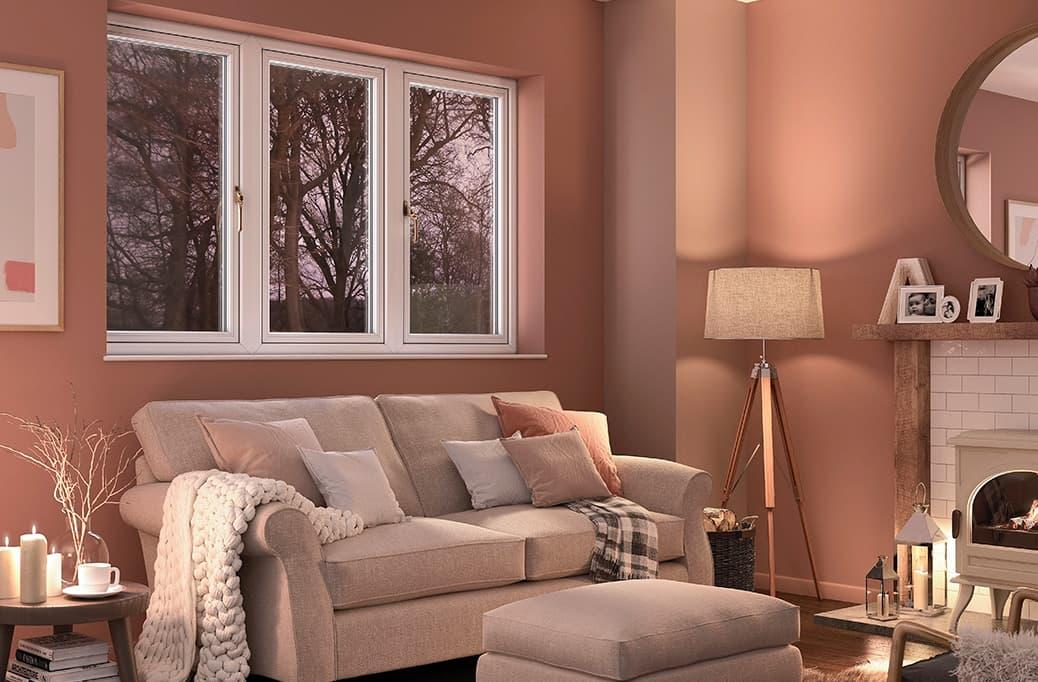

In [ ]:
idx = 16
image = test_data[idx]["image"]
image

In [ ]:
from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
preprocessor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-large-ade")

In [ ]:
inputs = processor(image, return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 800, 1248])
pixel_mask torch.Size([1, 800, 1248])


In [ ]:
import torch
model.to(device)
# forward pass
with torch.no_grad():
  outputs = model(**inputs.to(device))

[0 4]


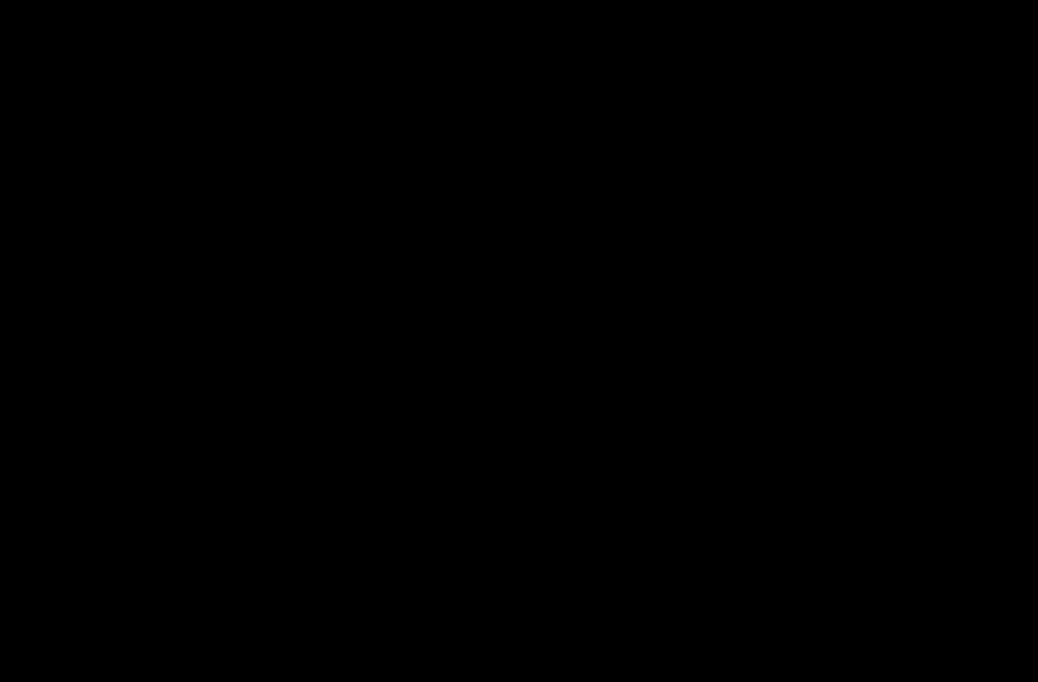

In [ ]:
results = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
data = (results.cpu().numpy())
print(np.unique(data))
mask=data==1
visual_mask = (mask * 255).astype(np.uint8)
visual_mask = Image.fromarray(visual_mask)
display(visual_mask)

In [ ]:
results = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(results.keys())
print(np.unique(results['segmentation']))

dict_keys(['segmentation', 'segments_info'])
[-1.  0.  1.]


In [ ]:
for segment in results['segments_info']:
  print(segment)

{'id': 0, 'label_id': 4, 'was_fused': False, 'score': 0.976051}
{'id': 1, 'label_id': 0, 'was_fused': False, 'score': 0.910728}


In [ ]:
import numpy as np

def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)

  return visual_mask

In [ ]:
np.unique(results['segmentation'].cpu().numpy())

array([-1.,  0.,  1.], dtype=float32)

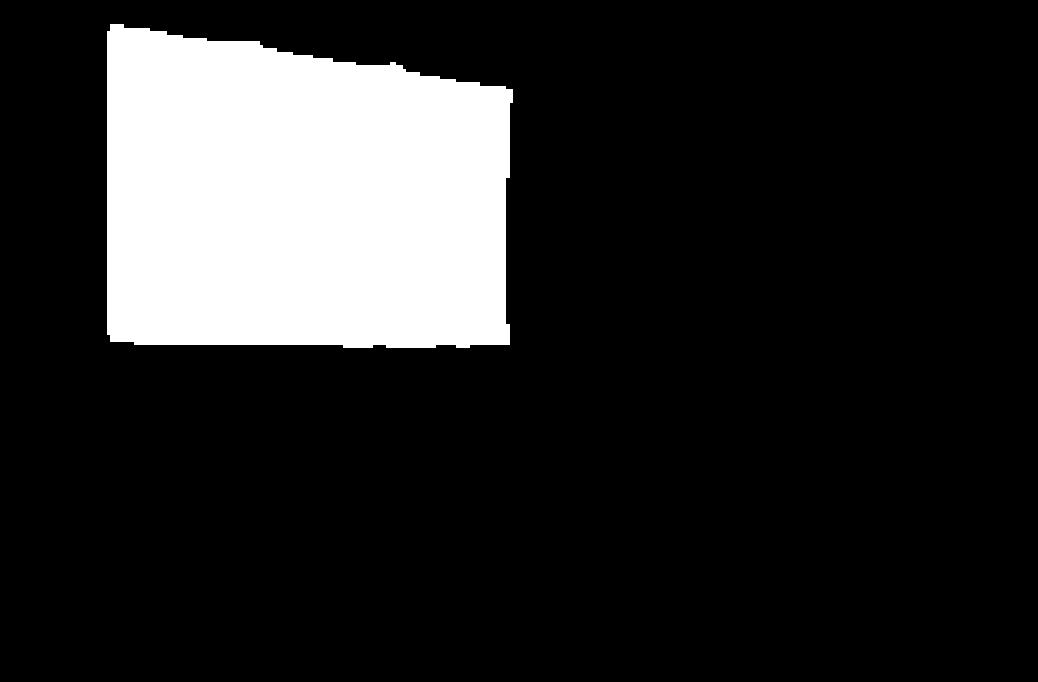

------


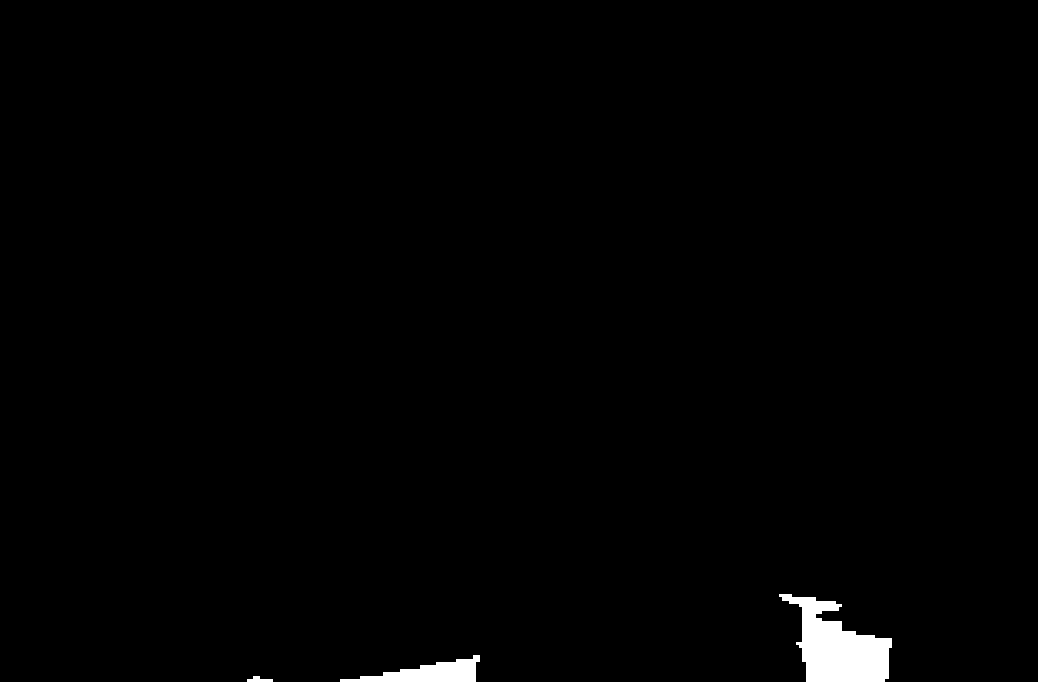

------


In [ ]:
for segment in results['segments_info']:
   # print("Visualizing mask for instance:", model.config.id2label[segment['label_id']])
    mask = get_mask(results['segmentation'], segment['id'])
    display(mask)
    print("------")

In [ ]:
def visualize_instance_seg_mask(mask):
    # Initialize image with zeros with the image resolution
    # of the segmentation mask and 3 channels
    image = np.zeros((mask.shape[0], mask.shape[1], 3))
    # Create labels
    labels = np.unique(mask)
    label2color = {
        label: (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
        )
        for label in labels
    }
    for height in range(image.shape[0]):
        for width in range(image.shape[1]):
            image[height, width, :] = label2color[mask[height, width]]
    image = image / 255
    return image


instance_seg_mask_disp = visualize_instance_seg_mask(instance_seg_mask)
plt.figure(figsize=(10, 10))

for plot_index in range(2):
    if plot_index == 0:
        plot_image = image
        title = "Original"
    else:
        plot_image = instance_seg_mask_disp
        title = "Segmentation"

    plt.subplot(1, 2, plot_index+1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")


NameError: name 'instance_seg_mask' is not defined

In [ ]:
!pip install evaluate tqdm
!pip show evaluate

Name: evaluate
Version: 0.4.1
Summary: HuggingFace community-driven open-source library of evaluation
Home-page: https://github.com/huggingface/evaluate
Author: HuggingFace Inc.
Author-email: leandro@huggingface.co
License: Apache 2.0
Location: /anaconda/envs/azureml_py38/lib/python3.8/site-packages
Requires: tqdm, responses, pandas, packaging, datasets, huggingface-hub, fsspec, dill, multiprocess, xxhash, numpy, requests
Required-by: 


In [ ]:
import evaluate
from tqdm import tqdm
metrics = evaluate.load("mean_iou")
# Set model in evaluation mode
model.eval()
# Test set doesn't have annotations so we will use the validation set
ground_truths, preds = [], []
for idx in tqdm(range(200)):
    image = test_data[idx]["image"].convert("RGB")
    target_size = image.size[::-1]
    # Get ground truth semantic segmentation map
    annotation = np.array(test_data[idx]["annotation"])[:,:,0]
    # Replace null class (0) with the ignore_index (255) and reduce labels
    annotation -= 1
    annotation[annotation==-1] = 255
    ground_truths.append(annotation)
    # Preprocess image
    inputs = processor(images=image, return_tensors="pt").to(device)
    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process results to retrieve semantic segmentation maps
    result = processor.post_process_semantic_segmentation(outputs, target_sizes=[target_size])[0]
    semantic_seg_mask = result.cpu().detach().numpy()
    preds.append(semantic_seg_mask)
results = metrics.compute(
    predictions=preds,
    references=ground_truths,
    num_labels=100,
    ignore_index=255
)
print(f"Mean IoU: {results['mean_iou']} | Mean Accuracy: {results['mean_accuracy']} | Overall Accuracy: {results['overall_accuracy']}")

  2%|▏         | 3/200 [00:01<02:09,  1.53it/s]


KeyboardInterrupt: 